The business problem we defined is how can we best determine the 

In [1]:
import pandas as pd
import numpy as np

# Now, let's try loading the processed data again
processed_data = pd.read_pickle('processed.pkl')


# Data Processing

Exclude NA, Inf values. 

A new column discount_degree has been created with three categories based on the discount_rate:

no_discount: for discount_rate >= 0  
low_discount: for 0 > discount_rate >= -30%  
high_discount: for discount_rate < -30%  

Here's the distribution of the discount degrees in the dataset:  
high_discount: 5,348 entries   
no_discount: 3,873 entries   
low_discount: 762 entries   


In [2]:
# First, we need to ensure that the 'discount_rate' column does not contain inf or NaN values
# We'll exclude such rows and then proceed with the feature engineering

# Remove rows where 'discount_rate' is inf or NaN
processed_pd = processed_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['discount_rate'])
# Creating a new column 'discount_degree' based on 'discount_rate' values
def classify_discount(discount_rate):
    if discount_rate >= 0:
        return 'no_discount'
    else: # discount_rate < -0.3
        return 'discount'

processed_pd['discount_degree'] = processed_pd['discount_rate'].apply(classify_discount)

# Checking the counts of each class
discount_degree_counts = processed_pd['discount_degree'].value_counts()
discount_degree_counts


discount       519856
no_discount    478112
Name: discount_degree, dtype: int64

In [3]:
processed_pd.head(10000).to_csv('processed_pd.csv', index=False)

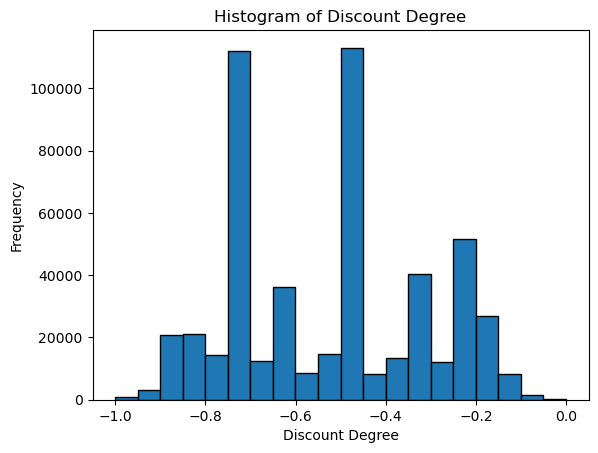

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your data in a DataFrame named 'processed_pd'
# You can replace 'processed_pd' with your actual DataFrame name

# Plot a histogram of the 'discount_degree' column
plt.hist(processed_pd[processed_pd['discount_rate']<0]['discount_rate'], bins=20, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Discount Degree')
plt.ylabel('Frequency')
plt.title('Histogram of Discount Degree')
plt.show()


# Feature Engineering

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Dropping the 'discount_degree' column from the dataset as it is our target variable
X = processed_pd.drop('discount_degree', axis=1)

# Identifying non-numeric columns that cannot be included in PCA
non_numeric_columns = X.select_dtypes(include=['object', 'datetime']).columns.tolist()

# Dropping the non-numeric columns from the dataset
X_numeric = X.drop(non_numeric_columns, axis=1)

# Standardizing the numeric data
scaler = StandardScaler()
X_std = scaler.fit_transform(X_numeric)

# Performing PCA without specifying the number of components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_std)

# Checking the shape of the resulting dataset to see how many components were retained
X_pca.shape, pca.explained_variance_ratio_


((997968, 5),
 array([0.03985733, 0.03691048, 0.03240739, 0.02781937, 0.0238695 ]))

# Logistics

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import numpy as np

# Prepare the target variable
y = processed_pd['discount_degree']

# Encoding the target variable since logistic regression needs a numerical input for classification
# Let's map 'no_discount' to 0 and 'high_discount' to 1
y_encoded = y.map({'no_discount': 0, 'discount': 1})

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluating the model
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

conf_matrix, auc_score


(array([[77460, 18042],
        [20595, 83497]]),
 0.8862958717127845)

# For Evaluation

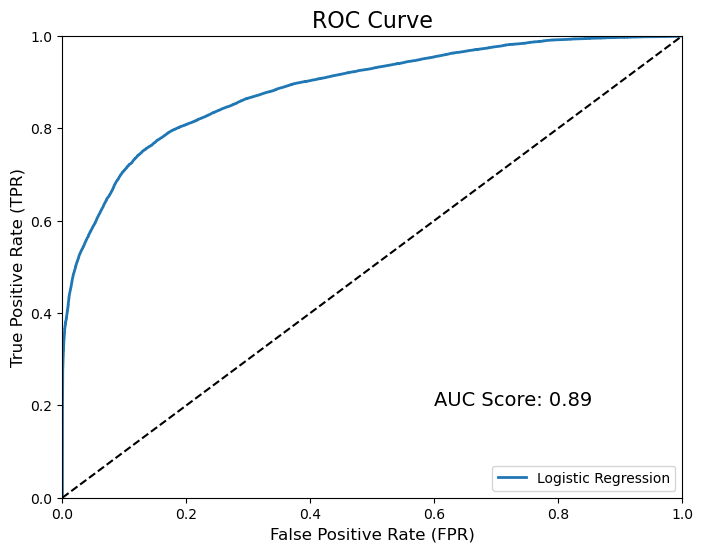

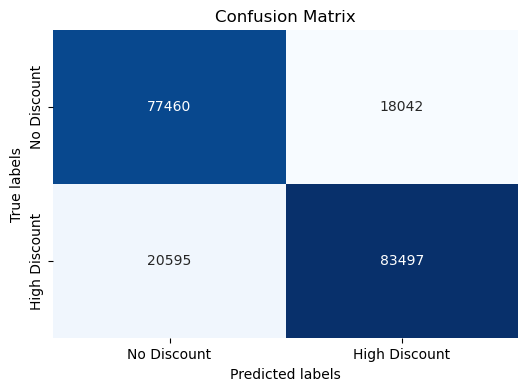

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the ROC Curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc="lower right")

# Calculate the FPR and TPR for plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotting the ROC Curve
plot_roc_curve(fpr, tpr, 'Logistic Regression')

# Show the AUC score on the plot
plt.text(0.6, 0.2, f'AUC Score: {auc_score:.2f}', fontsize=14)

# Display the plot
plt.show()

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Discount', 'High Discount'])
ax.yaxis.set_ticklabels(['No Discount', 'High Discount'])

# Display the heatmap
plt.show()


In [18]:
from sklearn.metrics import classification_report

# Generate the classification report with output_dict=True to get the report as a dictionary
report_dict = classification_report(y_test, y_pred, target_names=y_unique_values, output_dict=True)

# Convert the classification report dictionary into a DataFrame
class_report_df = pd.DataFrame(report_dict)

class_report_df[[]]




,no_discount,discount,accuracy,macro avg,weighted avg
precision,0.789965,0.822315,0.806422,0.806140,0.806836
recall,0.811082,0.802146,0.806422,0.806614,0.806422
f1-score,0.800384,0.812105,0.806422,0.806245,0.806497
support,95502.000000,104092.000000,0.806422,199594.000000,199594.000000


# SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Prepare the target variable (ensure you have both classes in the target variable)
y = processed_pd['discount_degree'].map({'no_discount': 0, 'discount': 1}).values

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize the SVM classifier
svm_model = SVC(probability=True)

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(report)


# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Assuming X_pca is your dataset after applying PCA and processed_pd is your original dataset
X = X_pca  # Your PCA reduced data
y = processed_pd['discount_degree']  # Target variable

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)

# Fit the model on the training data
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the accuracy and the classification report
print(f"Accuracy: {accuracy}")
print(report)


Accuracy: 0.8154653947513453
              precision    recall  f1-score   support

           0       0.86      0.78      0.81    104092
           1       0.78      0.86      0.82     95502

    accuracy                           0.82    199594
   macro avg       0.82      0.82      0.82    199594
weighted avg       0.82      0.82      0.82    199594



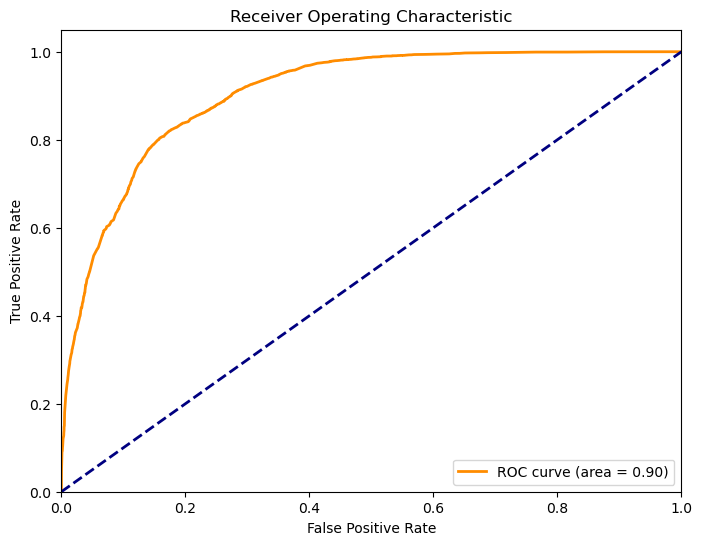

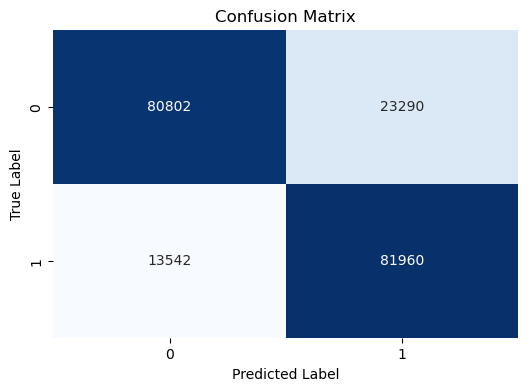

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Since Random Forest is not a linear model and does not output probabilities by default, we need to obtain the probabilities for the positive class
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for the model
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
